### Notes and codes from  Aurélien Géron:
### Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow
https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb

### Clustering for image segmentation
Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

By dividing an image into segments, you can process only the important segments of the image instead of processing the entire image.

Clustering can be used for image segmentation.

Keep in mind that k-means clustering may not work well for complex images with varying textures or overlapping regions, and more advanced techniques, such as hierarchical clustering or convolutional neural networks, may be required for such cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.cluster import KMeans

In [2]:
plt.rcParams['figure.figsize'] = (4, 4)

In [3]:
img = imread('ladybug.png')
img.shape

(533, 800, 3)

In [4]:
# Flatten the image
X = img.reshape(-1, 3)

kmeans = KMeans(n_clusters=8, random_state=42, n_init=10).fit(X)

In [5]:
# 8 clusters
kmeans.cluster_centers_

array([[0.98351526, 0.9358979 , 0.02575099],
       [0.02285829, 0.11067164, 0.00578478],
       [0.21914628, 0.38675895, 0.05800834],
       [0.75767696, 0.21229179, 0.04460662],
       [0.09990539, 0.2542202 , 0.01693691],
       [0.612661  , 0.63010174, 0.3875082 ],
       [0.37211823, 0.52359724, 0.15730515],
       [0.8845895 , 0.72559094, 0.03441923]], dtype=float32)

In [6]:
kmeans.labels_.shape

(426400,)

In [22]:
# assign a cluster (there are 8 clusters in this case) to every pixel
segmented_img = kmeans.cluster_centers_[kmeans.labels_]

In [23]:
segmented_img.shape

(426400, 3)

In [24]:
segmented_img = segmented_img.reshape((533, 800, 3))

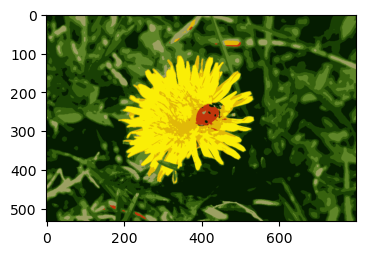

In [25]:
# 8 clusters
plt.imshow(segmented_img);

In [26]:
X = img.reshape(-1, 3)
segmented_imgs = []
nclusters = [20, 10, 6, 4, 2]
for n in nclusters:
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_img = segmented_img.reshape((533, 800, 3))
    segmented_imgs.append(segmented_img)

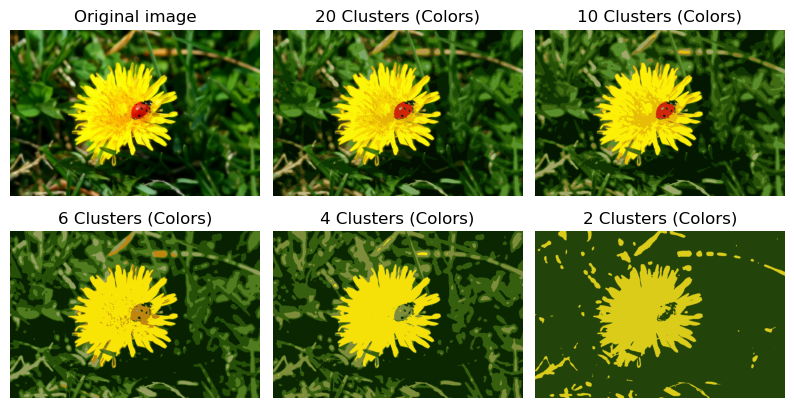

In [27]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

for i, n in enumerate(nclusters):
    plt.subplot(232 + i)
    plt.imshow(segmented_imgs[i])
    plt.title('{} Clusters (Colors)'.format(n))
    plt.axis('off')

### Clustering for Preprocessing

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [18]:
# MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9
X, y = load_digits(return_X_y=True)

In [19]:
X.shape

(1797, 64)

In [20]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# Fit a logistic regression model and evaluate on the test set
clf = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [23]:
clf.score(X_test, y_test)

0.9666666666666667

That's our baseline: 96.7% accuracy. 

Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [25]:
# UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.
# Whatever the memory leak is, it's tiny. For short-running jobs, the script will probably end 
# before the leak gets too bad, and the process will free the memory, hence we'll suppress the warning.

import warnings
warnings.filterwarnings('ignore')

In [26]:
# Use KMeans as preprocessing step (without Pipeline)
kmeans = KMeans(n_clusters=50, n_init=10, random_state=42)

# fit_transform: Compute clustering and transform X to cluster-distance space
X_train_clusters = kmeans.fit_transform(X_train)
X_test_clusters = kmeans.transform(X_test)

In [93]:
X_train_clusters.shape

(1347, 50)

In [27]:
clf = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
clf.fit(X_train_clusters, y_train)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [28]:
clf.score(X_test_clusters, y_test)

0.9822222222222222

In [29]:
# Use KMeans as preprocessing step (with Pipeline)
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, n_init=10, random_state=42)),
    ('clf', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, n_init=10, random_state=42)),
                ('clf',
                 LogisticRegression(multi_class='ovr', random_state=42,
                                    solver='liblinear'))])

In [30]:
pipeline.score(X_test, y_test)

0.9822222222222222

We chose the number of clusters, k, completely arbitrarily. Can we do better? The best value of k is simply the one that results in the best classification performance.

In [31]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, n_init=10,
                                               random_state=42)),
                                       ('clf',
                                        LogisticRegression(multi_class='ovr',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'kmeans__n_clusters': range(2, 100)})

In [32]:
grid_clf.best_params_

{'kmeans__n_clusters': 74}

In [33]:
grid_clf.score(X_test, y_test)

0.9822222222222222

### Clustering for semi-supervised learning
Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [91]:
n_label = 50
clf = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
clf.fit(X_train[:n_label], y_train[:n_label])
clf.score(X_test, y_test)

0.8266666666666667

Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [92]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

# fit_transform: Compute clustering and transform X to cluster-distance space
X_digits_dist = kmeans.fit_transform(X_train)

# For each column find the index of the min distance
representative_digit_idx = np.argmin(X_digits_dist, axis=0)

X_representative_digits = X_train[representative_digit_idx]

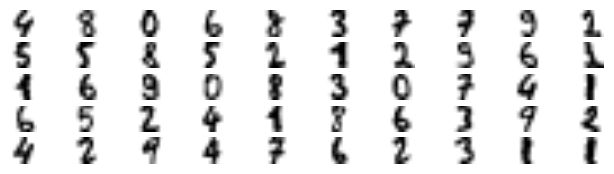

In [93]:
plt.figure(figsize=(8, 2))
for i, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k//10, 10, i+1)
    plt.imshow(X_representative_digit.reshape((8, 8)), cmap='binary', interpolation='bilinear')
    plt.axis('off')

In [94]:
# create the label for those 50 representative digits
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's fit a logistic regression model with our 50 representative digits, and see the performance on our test set:

In [95]:
clf = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
clf.fit(X_representative_digits, y_representative_digits)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [96]:
clf.score(X_test, y_test)

0.9222222222222223

We jumped from 82.7% accuracy to 92.4%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [97]:
y_train_propagated = np.empty(X_train.shape[0], dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [98]:
clf = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
clf.fit(X_train, y_train_propagated)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [99]:
clf.score(X_test, y_test)

0.9266666666666666

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [100]:
percentile_closest = 20
kmeans = KMeans(n_clusters=50, n_init=10, random_state=42)

# fit_transform: Compute clustering and transform X to cluster-distance space
X_digits_dist = kmeans.fit_transform(X_train)

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

In [101]:
for i in range(50):
    in_cluster = (kmeans.labels_==i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1 

In [102]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [103]:
clf = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
clf.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [104]:
clf.score(X_test, y_test)

0.9422222222222222

With just 50 labeled instances (just 5 examples per class on average!), we got 94.2% performance, which is pretty close to the performance of logistic regression on the fully labeled digits dataset (our baseline, which was 96.7%).

This is because the propagated labels are actually pretty good: their accuracy is very close to 99%:

In [105]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896193771626297

### Clustering part from: 02 End to end Machine Learning Project

In [106]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel

In [107]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [170]:
housing = load_housing_data()

In [141]:
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [171]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

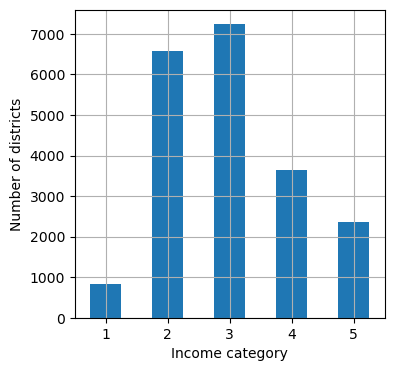

In [172]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts");

In [173]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [174]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [175]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [181]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [182]:
# Impute missing values
median_val = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median_val, inplace=True)

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [186]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

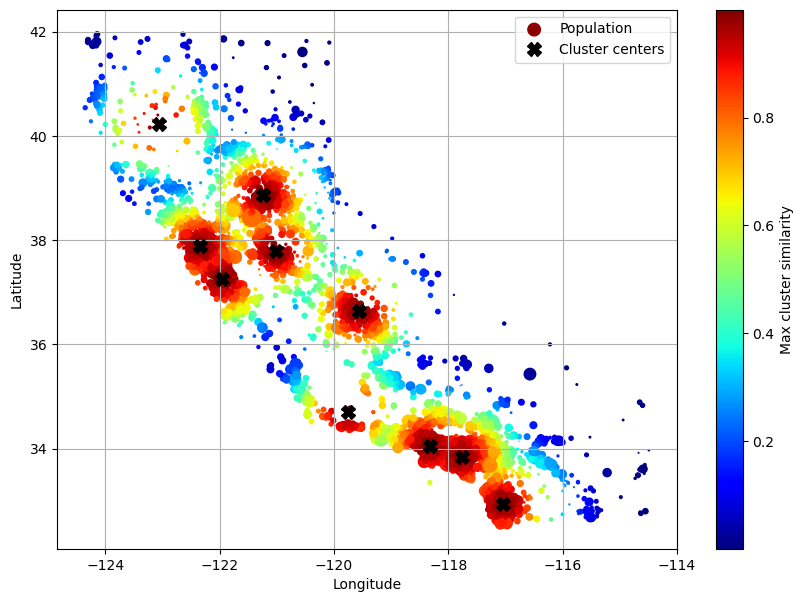

In [188]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=10,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### Clustering with K-Means - California Housing Dataset
As spatial features, 'latitude' and 'longitude' make natural candidates for k-means clustering. In this example we'll cluster these with 'median_income' to create economic segments in different regions of California.

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [138]:
df = pd.read_csv('datasets/housing/housing.csv')

In [139]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [127]:
X = df.loc[:, ['median_income', 'latitude', 'longitude']]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [128]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
cluster = kmeans.fit_predict(X_scaled)

In [129]:
X = pd.DataFrame(X_scaled, columns=X.columns)
X['cluster'] = cluster

In [130]:
X.head()

,median_income,latitude,longitude,cluster
0,0.539668,0.567481,0.211155,4
1,0.538027,0.565356,0.212151,4
2,0.466028,0.564293,0.210159,4
3,0.354699,0.564293,0.209163,4
4,0.230776,0.564293,0.209163,5


In [131]:
X['cluster'] = X['cluster'].astype('category')

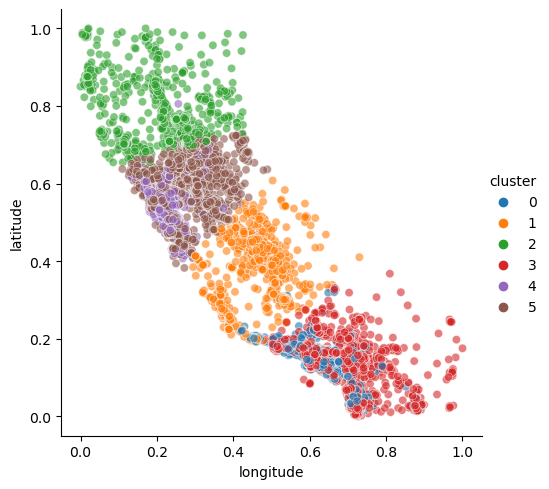

In [155]:
sns.relplot(x='longitude', y='latitude', hue='cluster', alpha=0.6, data=X);

The scatter plot that shows the geographic distribution of the clusters. It seems like the algorithm has created separate segments for higher-income areas on the coasts (San Francisco and its nearby areas).

The target in this dataset is median_house_value. The box-plots below show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across median_house_value, which is indeed what we see.

In [189]:
X['median_house_value'] = df['median_house_value']

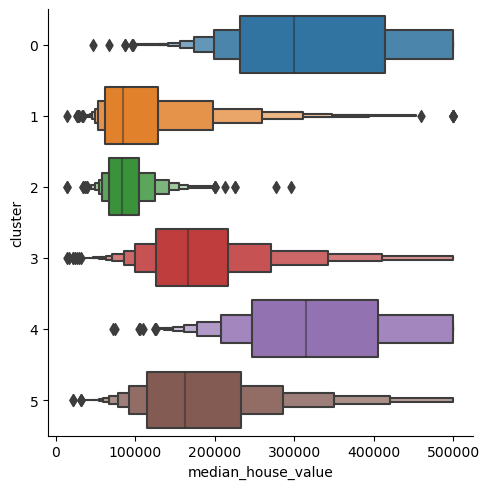

In [134]:
sns.catplot(x='median_house_value', y='cluster', data=X, kind='boxen');